In [1]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
import statsmodels.api as sm
import hashlib

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,30,32,33,91,799,800] #C2
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '130_20220707', '152_20201224', '30_20220509',
       '32_20220428', '33_20220502', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


In [3]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)


In [4]:
column = "num_spores"
plate_select = time_plate_info.loc[~time_plate_info[column].isnull()]['Plate'].unique().tolist()
folders['CrossDate'] = folders['CrossDate'].astype(str).str.replace("'","").astype(int)
plate_2022 = folders.loc[folders['CrossDate']>20220101]['Plate'].unique()
plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_select]
# plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_2022]
plate_select = [int(plate.split('_')[0])  for plate in plates]

In [5]:
plate_select

[1014,
 1023,
 102,
 1042,
 1045,
 1048,
 1053,
 1076,
 127,
 130,
 152,
 30,
 32,
 33,
 52,
 84,
 91,
 938]

In [6]:
selection = time_plate_info.loc[time_plate_info['Plate'].isin(plate_select)]


In [20]:
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1076_20220511',
        '130_20220707', '152_20201224', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
plate_select = [int(plate.split('_')[0])  for plate in plates]

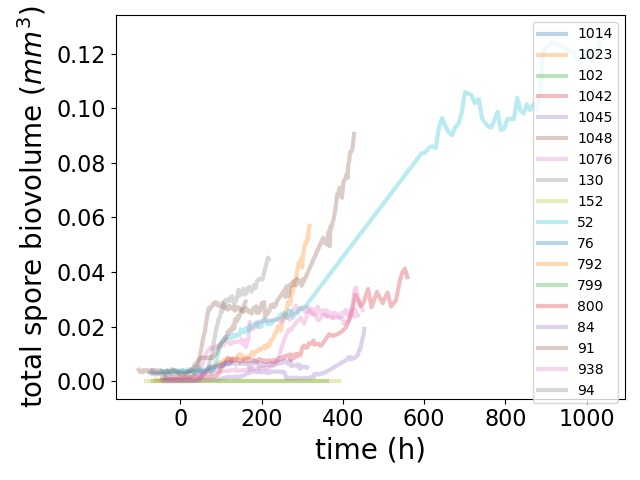

In [21]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['spore_volume']/1e9,label=plate,alpha=0.3)
ax.set_xlabel('time (h)')
ax.set_ylabel('total spore biovolume ($mm^{3}$)')
plt.tight_layout()
plt.legend()

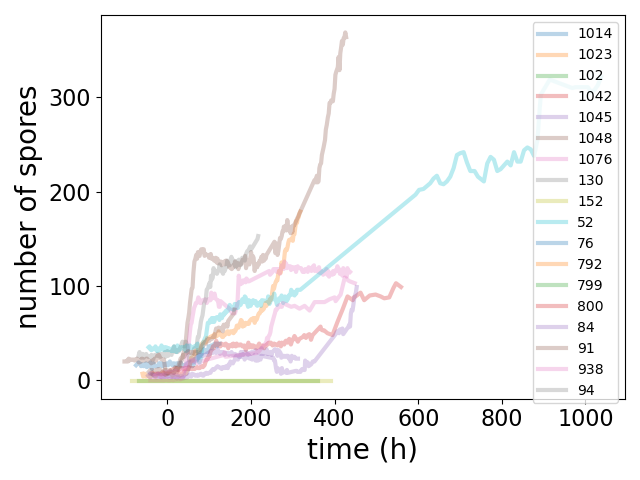

In [22]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['num_spores'],label=plate,alpha=0.3)
ax.set_xlabel('time (h)')
ax.set_ylabel('number of spores')
plt.tight_layout()
plt.legend()

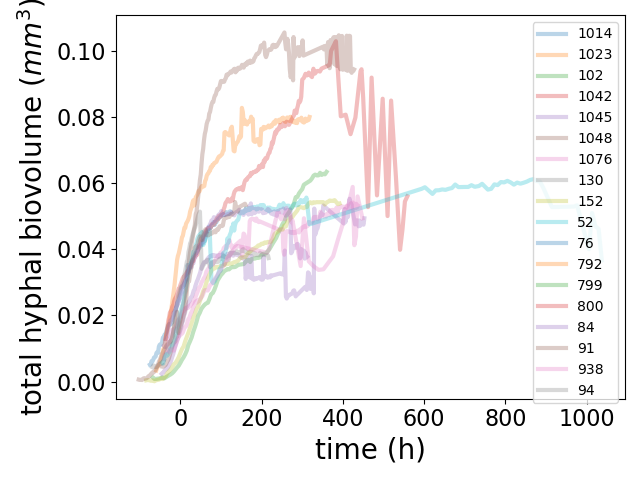

In [23]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['tot_biovolume_study']/1e9,label=plate,alpha=0.3)
ax.set_xlabel('time (h)')
ax.set_ylabel('total hyphal biovolume ($mm^{3}$)')
plt.tight_layout()
plt.legend()

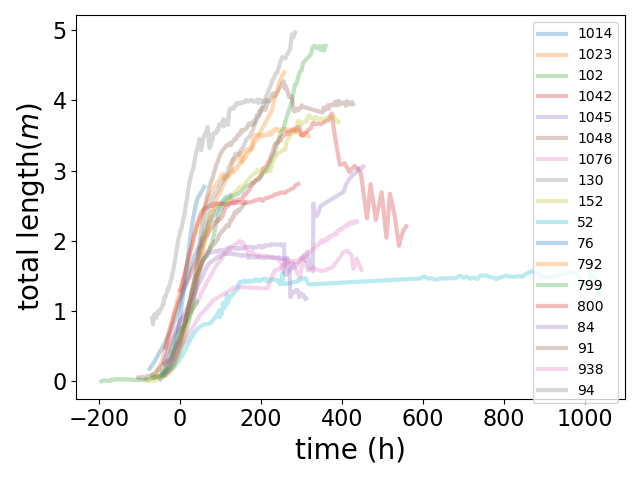

In [24]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['tot_length_study']/1e6,label=plate,alpha=0.3)
ax.set_xlabel('time (h)')
ax.set_ylabel('total length($m$)')
plt.tight_layout()
plt.legend()

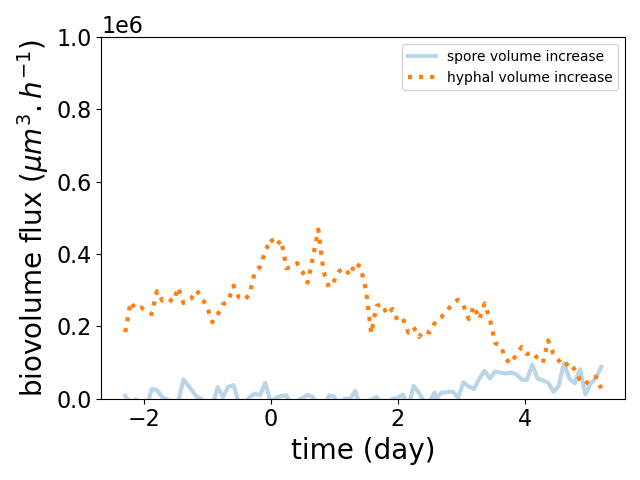

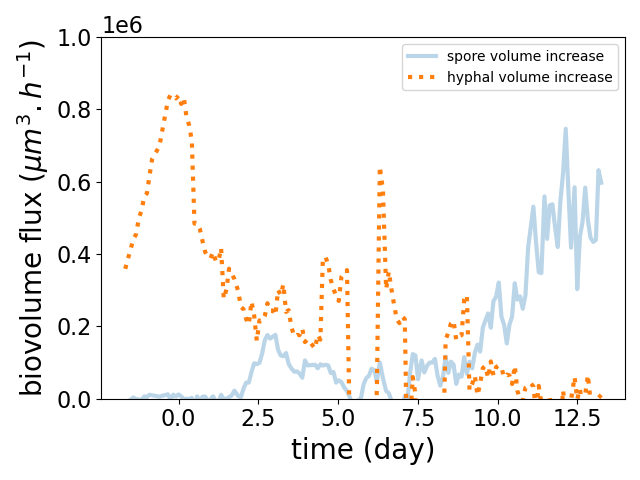

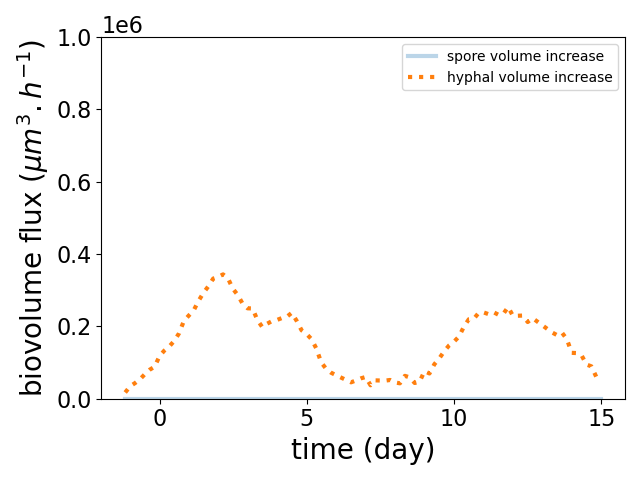

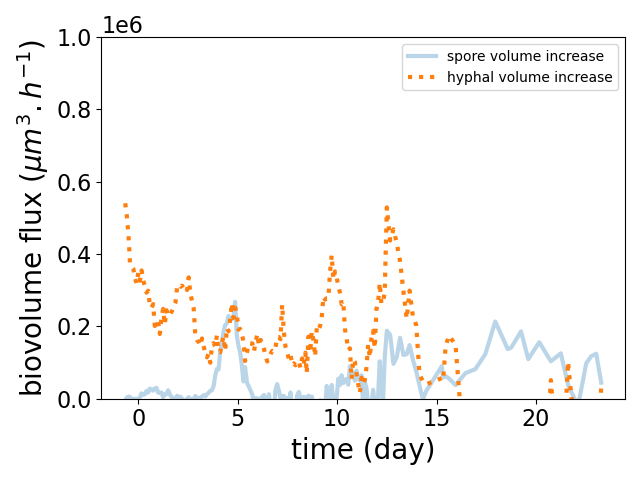

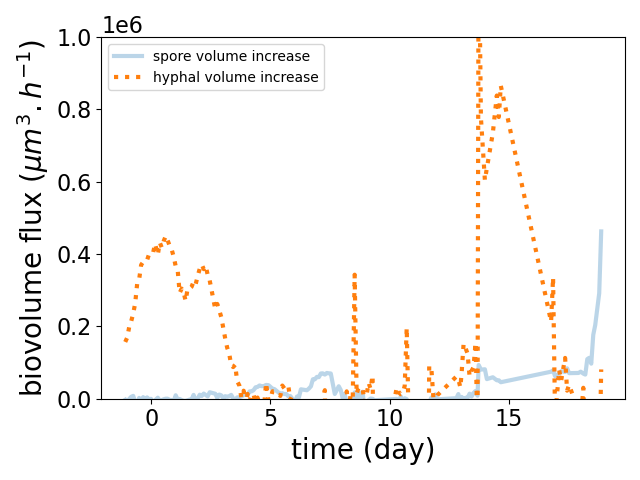

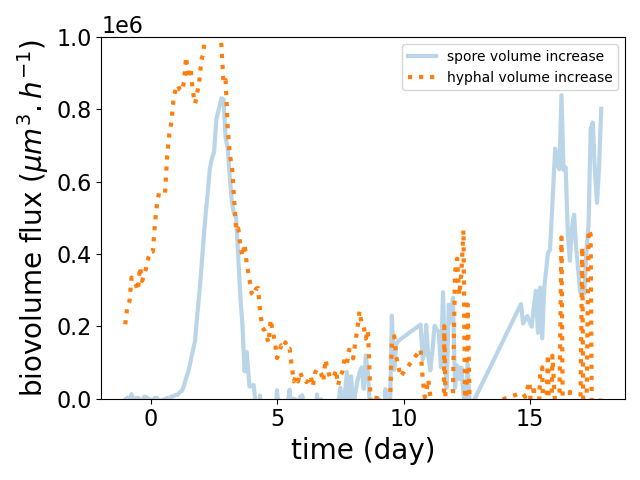

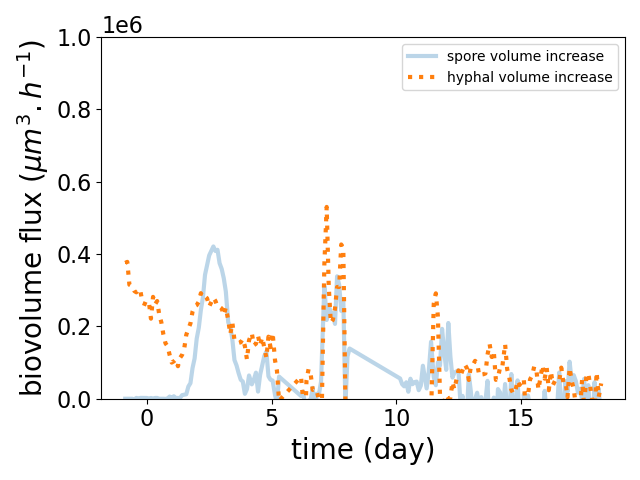

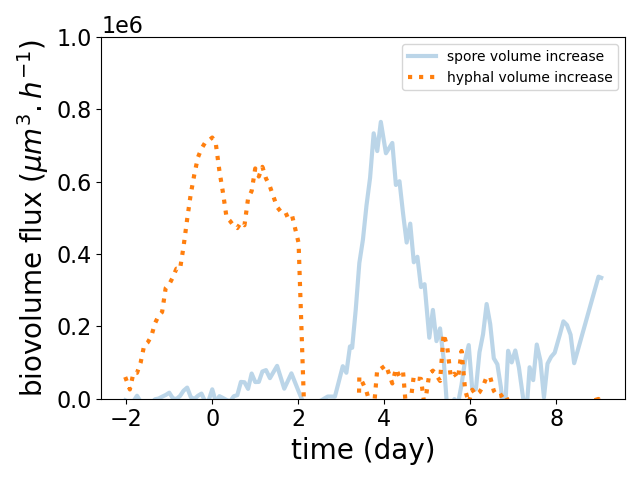

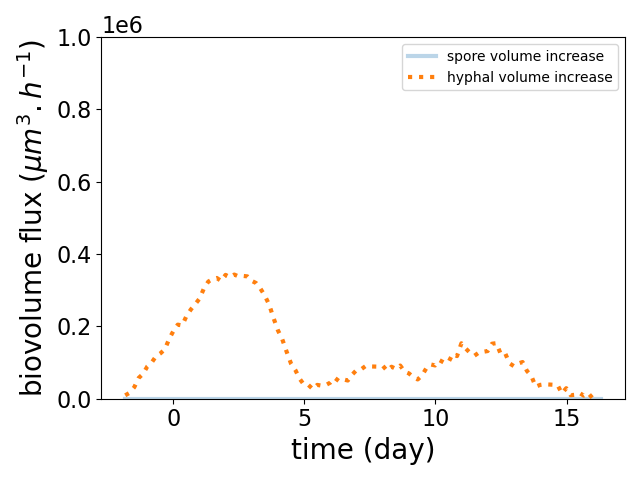

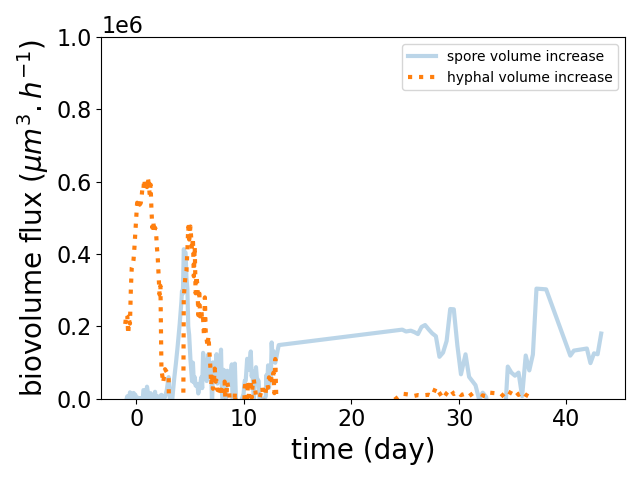

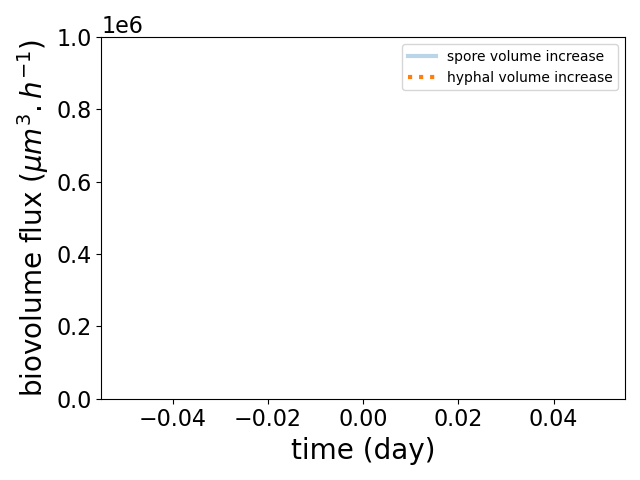

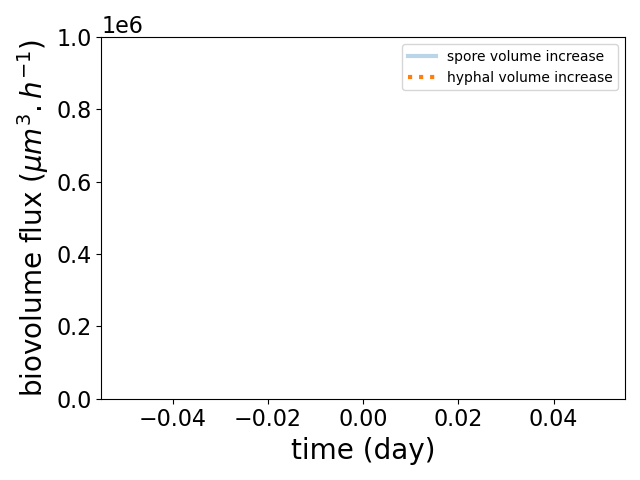

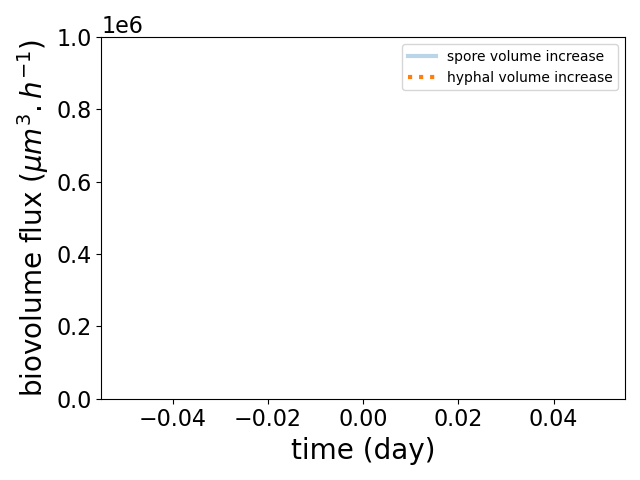

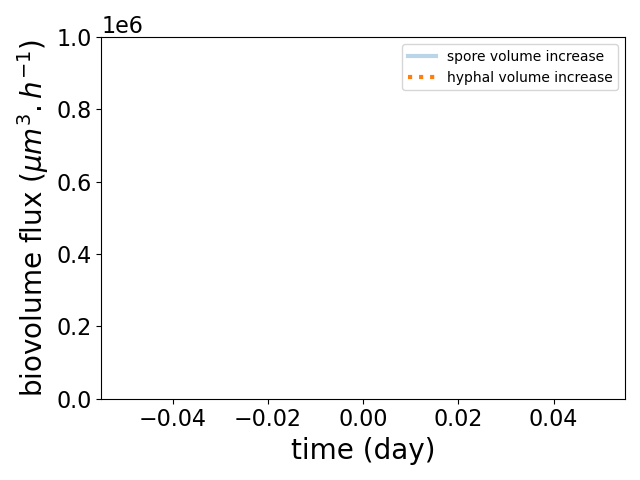

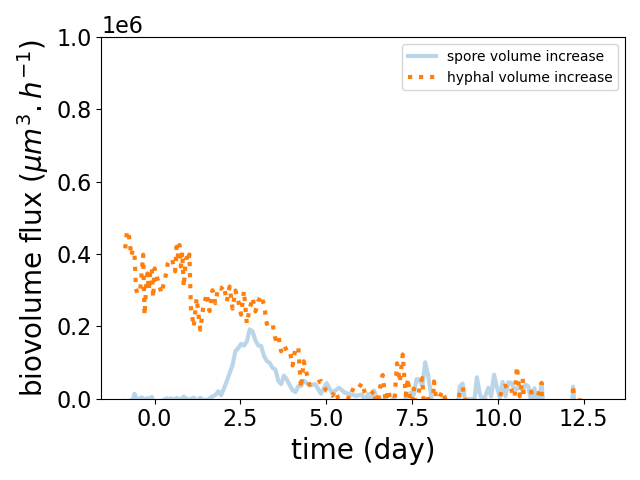

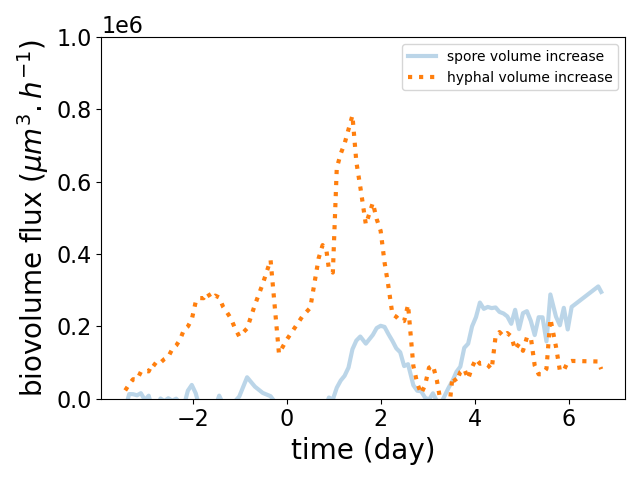

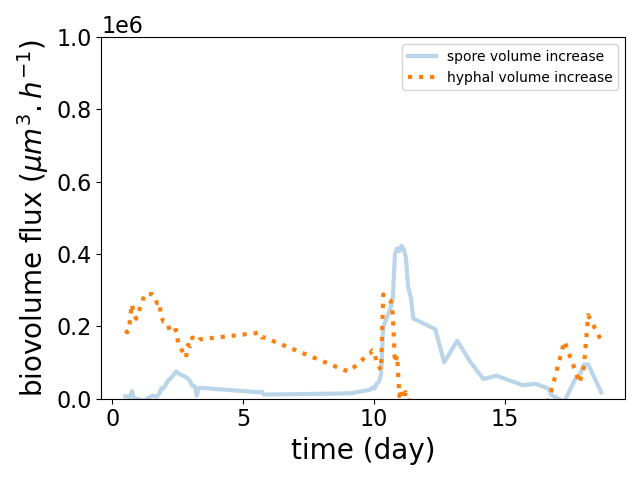

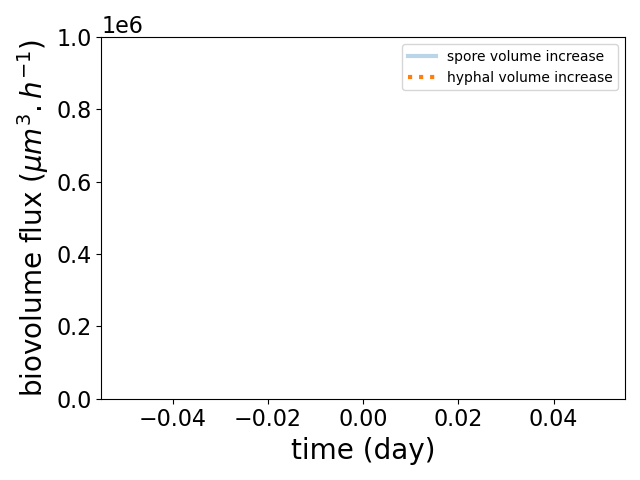

In [25]:
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []

for j in range(len(plates)):
    fig,ax=plt.subplots()
    
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    time_plate_info_plate['spore_volume_increase_flux'] = time_plate_info_plate['spore_volume'].diff(10)/time_plate_info_plate['time_since_begin_h'].diff(10)
    time_plate_info_plate['hyphal_volume_increase_flux'] = time_plate_info_plate['tot_biovolume_study'].diff(10)/time_plate_info_plate['time_since_begin_h'].diff(10)
    time_plate_info.loc[time_plate_info['unique_id']==int(plate_id),'spore_volume_increase_flux'] = time_plate_info_plate['spore_volume_increase_flux']
    ax.plot(time_plate_info_plate['time_since_begin_h_correct']/24,time_plate_info_plate['spore_volume_increase_flux'],label="spore volume increase",alpha=0.3)
    ax.plot(time_plate_info_plate['time_since_begin_h_correct']/24,time_plate_info_plate['hyphal_volume_increase_flux'],label="hyphal volume increase",linestyle="dotted")
    ax.legend()
    ax.set_xlabel('time (day)')
    ax.set_ylabel('biovolume flux ($\mu m^{3}.h^{-1}$)')
    ax.legend()
    ax.set_ylim(0,1e6)
    plt.tight_layout()
    

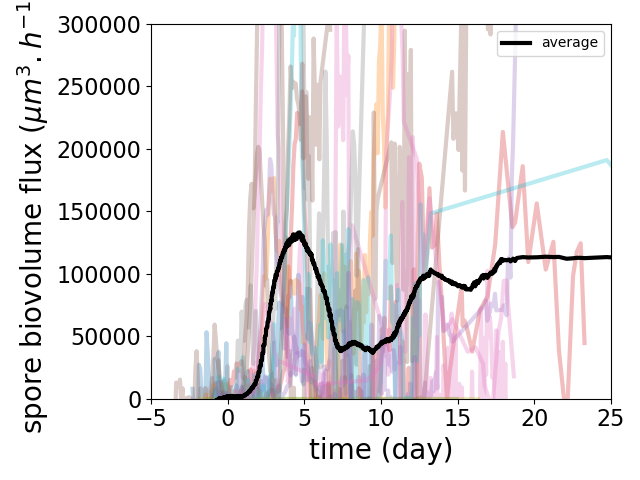

In [29]:
plate_num_alternative = [int(plate) for plate in plates]
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
fig,ax=plt.subplots()

for j in range(len(plates)):
    
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    time_plate_info_plate['spore_volume_increase_flux'] = time_plate_info_plate['spore_volume'].diff(10)/time_plate_info_plate['time_since_begin_h'].diff(10)
    
    time_plate_info_plate['hyphal_volume_increase_flux'] = time_plate_info_plate['tot_biovolume_study'].diff(10)/time_plate_info_plate['time_since_begin_h'].diff(10)
    time_plate_info.loc[time_plate_info['unique_id']==int(plate_id),'spore_volume_increase_flux'] = time_plate_info_plate['spore_volume_increase_flux']
   
    time_plate_info.loc[time_plate_info['unique_id']==int(plate_id),'time_since_begin_h_correct'] = time_plate_info_plate['time_since_begin_h_correct']
# time_plate_info.loc[time_plate_info['unique_id']==int(plate_id),'spore_volume_increase_flux'] = 5
    
    ax.plot(time_plate_info_plate['time_since_begin_h_correct']/24,time_plate_info_plate['spore_volume_increase_flux'],alpha=0.3)
    # ax.plot(time_plate_info_plate['time_since_begin_h_correct']/24,time_plate_info_plate['hyphal_volume_increase_flux'],label="hyphal volume increase",linestyle="dotted")

    plt.tight_layout()
select = time_plate_info.loc[time_plate_info['unique_id'].isin(plate_num_alternative)].copy()
select = select.sort_values('time_since_begin_h_correct')
select['mean_biovolume_increase'] = select.rolling(300,min_periods = 9)["spore_volume_increase_flux"].mean()

ax.plot(select['time_since_begin_h_correct']/24,select['mean_biovolume_increase'],color='black',label = 'average')
ax.set_xlabel('time (day)')
ax.set_ylabel('spore biovolume flux ($\mu m^{3}.h^{-1}$)')
ax.set_ylim(0,3e5)
ax.legend()

ax.set_xlim(-5,25)
plt.tight_layout()

In [44]:
select['spore_volume_increase_flux']

100               NaN
101               NaN
102               NaN
103               NaN
104               NaN
            ...      
1862    523955.624294
1863    479117.722985
1864    567171.984793
1865    627116.768670
1866    569701.937098
Name: spore_volume_increase_flux, Length: 906, dtype: float64

In [30]:
time_plate_info['spore_volume_increase_flux']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
3305   NaN
3306   NaN
3307   NaN
3308   NaN
3309   NaN
Name: spore_volume_increase_flux, Length: 3310, dtype: float64

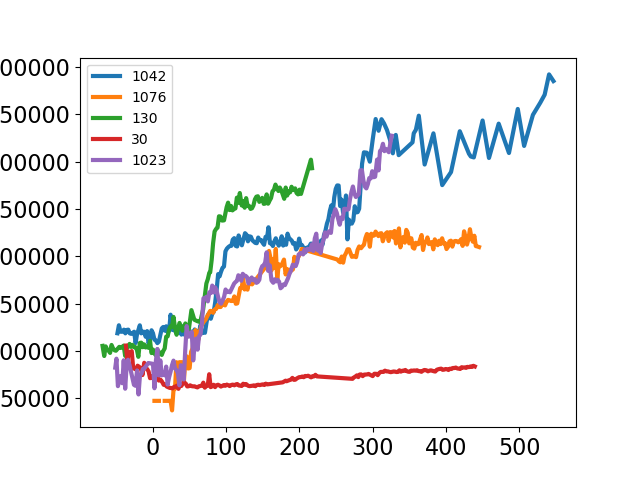

In [18]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['spore_volume']/time_plate_info_plate['num_spores'],label=plate)
selection['num_spores']
plt.legend()

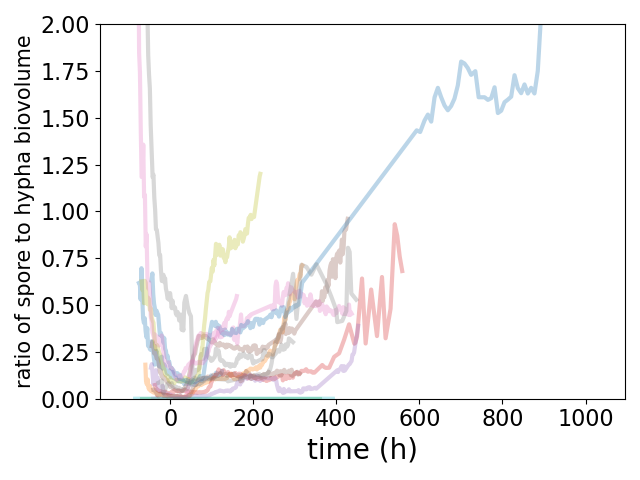

In [99]:
fig,ax=plt.subplots()
colors_strain = {"'A5'" : 'orange',"'A5sp3'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
length_increments = []
strains = []
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    time_plate_info_plate = time_plate_info.loc[time_plate_info['unique_id']==int(plate_id)].copy()
    time_plate_info_plate = time_plate_info_plate.sort_values(by = 'time_since_begin_h')
    strain = time_plate_info_plate['strain'].iloc[0]
    from_init = time_plate_info_plate.loc[time_plate_info_plate['area_sep_comp']>=500]
    t0 = np.min(from_init['time_since_begin_h'])
    time_plate_info_plate['time_since_begin_h_correct']=time_plate_info_plate['time_since_begin_h']-t0
    ax.plot(time_plate_info_plate['time_since_begin_h_correct'],time_plate_info_plate['spore_volume']/time_plate_info_plate['tot_biovolume_study'],label=plate,alpha = 0.3)
selection['num_spores']
ax.set_xlabel('time (h)')
ax.set_ylabel('ratio of spore to hypha biovolume',size = 15)
ax.set_ylim(0,2)
plt.tight_layout()
# plt.legend()